In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.callbacks import Callback

import pandas as pd
import cirq
import sympy
import numpy as np
import scipy
from scipy.linalg import eigh, cholesky
from scipy.stats import norm, multivariate_normal

from pylab import plot, show, axis, subplot, xlabel, ylabel, grid

# visualization tools
import seaborn as sns
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import IPython

sns.set()
plt.rcParams['figure.figsize'] = [10, 5]
InteractiveShell = IPython.core.interactiveshell.InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
tf.random.set_seed(5)

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np


class VThresh(keras.layers.Layer):
    """Parameterized quantum signal processing layer.

    The `QSP` layer implements the quantum signal processing circuit with trainable QSP angles.

    The input of the layer is/are theta(s) where x = cos(theta), and w(x) is X rotation in the QSP sequence.

    The output is the real part of the upper left element in the resulting unitary that describes the whole sequence.
    This is Re[P(x)] in the representation of the QSP unitary from Gilyen et al.

    Input is of the form:
    [[theta1], [theta2], ... ]

    Output is of the form:
    [[P(x1)], [P(x2)], ...]

    The layer requires the desired polynomial degree of P(x)

    """

    def __init__(self, poly_deg=0):
        """
        Params
        ------
        poly_deg: The desired degree of the polynomial in the QSP sequence.
            the layer will be parameterized with poly_deg + 1 trainable phi.
        """
        super(VThresh, self).__init__()
        self.poly_deg = poly_deg
        phi_init = tf.random_uniform_initializer(minval=0, maxval=np.pi)
        self.phis = tf.Variable(
            initial_value=phi_init(shape=(poly_deg, 1), dtype=tf.float32),
            trainable=True,
        )
    
    def unitary(self, inp, verbose=False):
        """
        Shadow QSP 
        q0 ---
        q1 ---
        Order 
            phi[q1], controlled U[q0,q1], V[q0]
            d times
        """
        th = inp[:,None,0]
        eps = inp[:,None,1]
        batch_dim = tf.gather(tf.shape(th), 0)
        
        
        # tiled up X rotations (input W(x))
        px = tf.constant([[0.0, 1], [1, 0]], dtype=tf.complex64)
        px = tf.expand_dims(px, axis=0)
        px = tf.repeat(px, [batch_dim], axis=0)
        
        rot_x_arg = tf.complex(real=0.0, imag=th)
        rot_x_arg = tf.expand_dims(rot_x_arg, axis=1)
        rot_x_arg = tf.tile(rot_x_arg, [1, 2, 2])
        

        wx = tf.linalg.LinearOperatorFullMatrix(tf.linalg.expm(tf.multiply(px, rot_x_arg)))

        c_op = tf.linalg.LinearOperatorFullMatrix(tf.constant([[0, 0], [0, 1]], dtype=tf.complex64))
        c_op = tf.linalg.LinearOperatorKronecker([c_op, wx])
        i_op = tf.constant([[[1.0,0,0,0], 
                            [0,1,0,0],
                            [0,0,0,0],
                            [0,0,0,0]]], dtype=tf.complex64)
        i_op = tf.repeat(i_op, [batch_dim], axis=0)
        c_op = c_op.to_dense() + i_op
        
        # tiled up V rotations

        px = tf.constant([[0.0, 1], [1, 0]], dtype=tf.complex64)
        px = tf.expand_dims(px, axis=0)
        px = tf.repeat(px, [batch_dim], axis=0)
        
        
        rot_v_arg = tf.complex(real=0.0, imag=eps)
        rot_v_arg = tf.expand_dims(rot_v_arg, axis=1)
        rot_v_arg = tf.tile(rot_v_arg, [1, 2, 2])
        
        rv = tf.linalg.LinearOperatorFullMatrix(tf.linalg.expm(tf.multiply(px, rot_v_arg)))

        pi = tf.linalg.LinearOperatorFullMatrix(tf.constant([[1, 0], [0, 1]], dtype=tf.complex64))
        v_op = tf.linalg.LinearOperatorKronecker([rv, pi]).to_dense()
        
        
        # tiled up Z rotations
        pz = tf.constant([[1.0, 0], [0, -1]], dtype=tf.complex64)
        pz = tf.expand_dims(pz, axis=0)
        pz = tf.repeat(pz, [batch_dim], axis=0)

        z_rotations = []
        for k in range(self.poly_deg):
            phi = self.phis[k]
            rot_z_arg = tf.complex(real=0.0, imag=phi)
            rot_z_arg = tf.expand_dims(rot_z_arg, axis=0)
            rot_z_arg = tf.expand_dims(rot_z_arg, axis=0)
            rot_z_arg = tf.tile(rot_z_arg, [batch_dim, 2, 2])

            rz = tf.linalg.LinearOperatorFullMatrix(tf.linalg.expm(tf.multiply(pz, rot_z_arg)))
            pi = tf.linalg.LinearOperatorFullMatrix(tf.constant([[1, 0], [0, 1]], dtype=tf.complex64))
            rz = tf.linalg.LinearOperatorKronecker([pi, rz]).to_dense()
            z_rotations.append(rz)
            
        extra = []
        # initial state 
        init_state = self.random_init_state(batch_dim)
        
        
        u = z_rotations[0]
        u = tf.matmul(c_op, u)
        u = tf.matmul(v_op, u)
        for rz in z_rotations[1:]:
            if verbose:
                final_state = tf.matmul(u,init_state)
                extra.append(tf.norm(tf.reshape(final_state, (batch_dim, 2, 2))[:,:,0],axis=1))
            u = tf.matmul(rz, u)
            u = tf.matmul(c_op, u)
            u = tf.matmul(v_op, u)
        
        
        final_state = tf.matmul(u,init_state)
        final_state = tf.reshape(final_state, (batch_dim, 2, 2))
        # expectation 
        exp = tf.norm(final_state[:,:,0],axis=1)
        
        if verbose:
            return exp, extra
        return exp
    
    def random_init_state(self, batch_dim):
        px = tf.tile(tf.constant([[[0.0,1], [1,0]]], dtype=tf.complex64),[batch_dim,1,1])

        init_env_rot_ang = tf.tile(
            tf.complex(
                real=0.0, 
                imag=tf.random.uniform(
                    (batch_dim,1,1), minval=0, maxval=np.pi/2, dtype=tf.dtypes.float32
                )
            ),
            [1,2,2]
        )

        init_env_rot = tf.linalg.LinearOperatorFullMatrix(tf.linalg.expm(tf.multiply(px, init_env_rot_ang)))
        pi = tf.linalg.LinearOperatorFullMatrix(tf.constant([[1,0],[0,1]], dtype=tf.complex64))
        init_env_rot = tf.linalg.LinearOperatorKronecker([init_env_rot,pi]).to_dense()
        init_state = tf.matmul(init_env_rot, [[1],[0],[0],[0]])
        
        return init_state
    
    def call(self, inp):
        return tf.abs(self.unitary(inp))
#         e = tf.matvec(u,s)
#         e = tf.matvec(f,u)
#         return tf.norm(e)

def frobenius_norm(y,x):
    u = x-y
    u = tf.norm(u, ord='euclidean',axis=1)
    u = tf.norm(u, ord='euclidean',axis=1)
    return u


class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            print("Early stopping requires %s available!" % self.monitor)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
            
            
def construct_qsp_model2(poly_deg):
    """Helper function that compiles a QSP model with mean squared error and adam optimizer.

    Params
    ------
    poly_deg : int
        the desired degree of the polynomial in the QSP sequence.

    Returns
    -------
    Keras model
        a compiled keras model with trainable phis in a poly_deg QSP sequence.
    """
    theta_input = tf.keras.Input(shape=(2,), dtype=tf.float32, name="theta")
    qsp = VThresh(poly_deg)
    u = qsp(theta_input)
    model = tf.keras.Model(inputs=theta_input, outputs=u)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(optimizer=optimizer, loss=loss)
    return qsp, model


theta x: pi/2, theta v : pi/8, trained: True


tf.Tensor([0.5003858+0.j 1.0000005+0.j], shape=(2,), dtype=complex64)


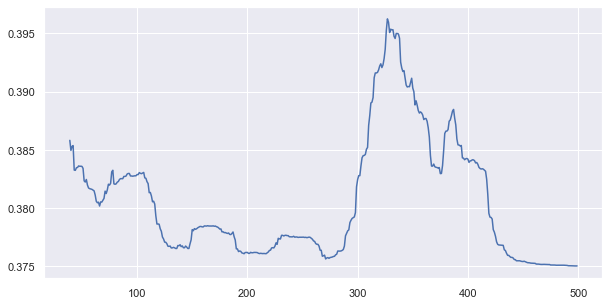

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

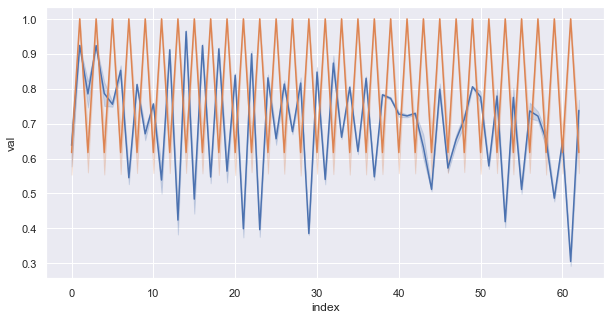

theta x: pi/2, theta v : pi/8, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

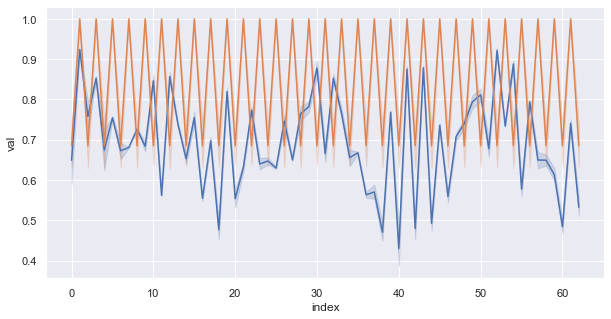

theta x: pi/2, theta v : pi/3, trained: True


tf.Tensor([0.50894636+0.j 1.0000002 +0.j], shape=(2,), dtype=complex64)


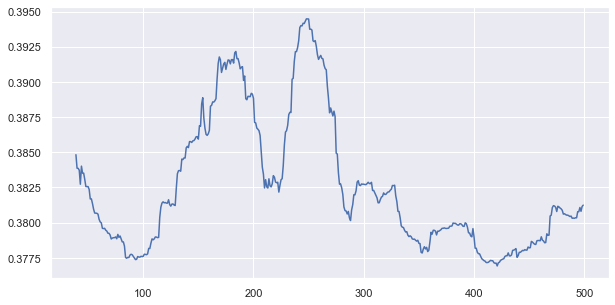

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

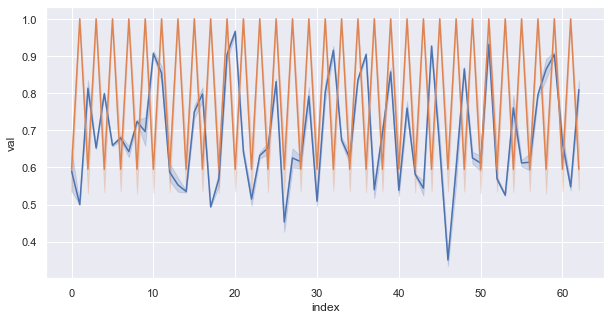

theta x: pi/2, theta v : pi/3, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

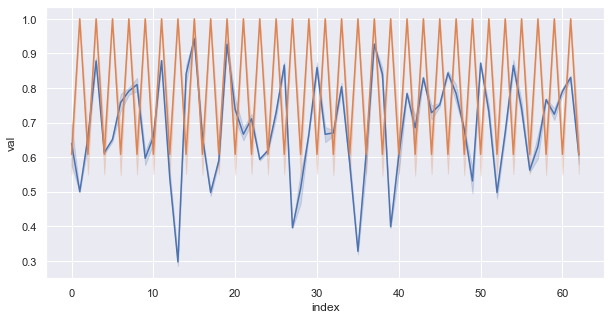

theta x: pi/8, theta v : pi/8, trained: True


tf.Tensor([0.4648653+0.j 0.7995831+0.j], shape=(2,), dtype=complex64)


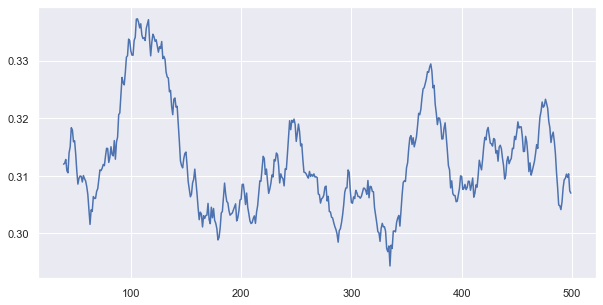

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

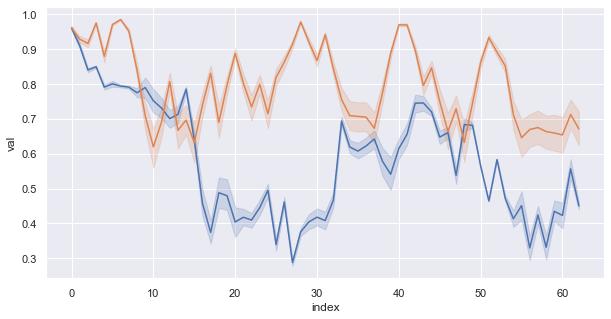

theta x: pi/8, theta v : pi/8, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

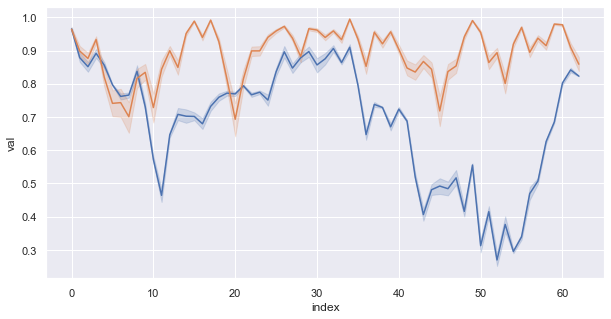

theta x: pi/8, theta v : pi/2, trained: True


tf.Tensor([0.46427408+0.j 0.95070744+0.j], shape=(2,), dtype=complex64)


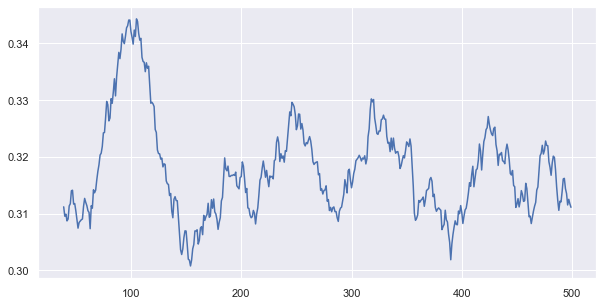

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

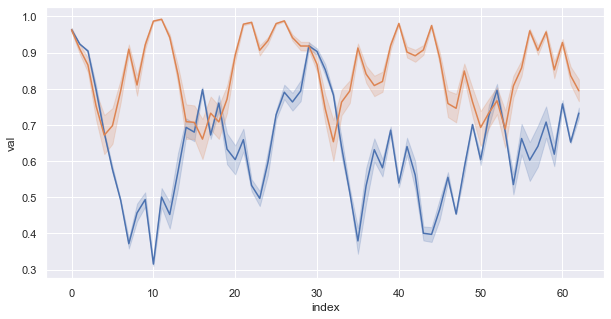

theta x: pi/8, theta v : pi/2, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

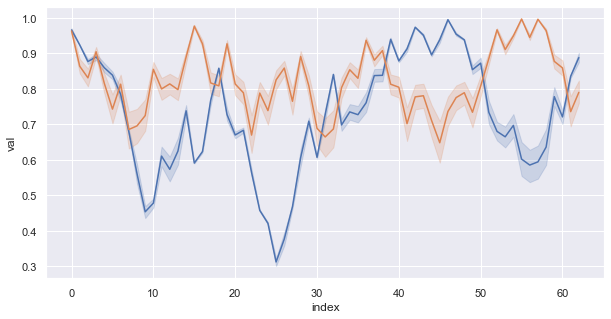

In [17]:
for n, nv in [(2,8), (2,3), (8,8), (8,2)]:
    wx = np.pi/n
    v = np.pi/nv # x rotation
    poly_deg = 64
    
    for train in (True, False):
        print("theta x: pi/%s, theta v : pi/%s, trained: %s" % (n,nv, train))
        
        # The intput theta training values 
        th_in = tf.constant([[wx,v],[wx,0]],dtype=tf.float32)
        # The desired real part of p(x) which is the upper left value in the unitary of the qsp sequence
        expected_outputs = tf.constant([[0,1],[1,0]], dtype=tf.float32)


        qsp, model = construct_qsp_model2(poly_deg)
        
        if train:
            history = model.fit(x=th_in, y=expected_outputs, epochs=500,verbose=0)
            loss = pd.Series(history.history['loss'])
            plt.plot(loss.rolling(40).mean().dropna())
            print(qsp.unitary(th_in))

            plt.show()
            
        noise = []
        no_noise = []
        index = []
        for _ in range(100):
            final, intermediate = qsp.unitary(th_in, True )

            noise.extend([float(t[0]) for t in intermediate])
            no_noise.extend([float(t[1]) for t in intermediate])
            index.extend([i for i in range(len(intermediate))])
        noise = pd.DataFrame({"val": noise, "index": index})
        no_noise = pd.DataFrame({"val": no_noise, "index": index})
        sns.lineplot(data=noise, x="index", y="val")
        sns.lineplot(data=no_noise, x="index", y="val")
        plt.show()

theta x: pi/8, theta v : pi/4, trained: True


tf.Tensor([0.30767906+0.j 0.57995176+0.j], shape=(2,), dtype=complex64)


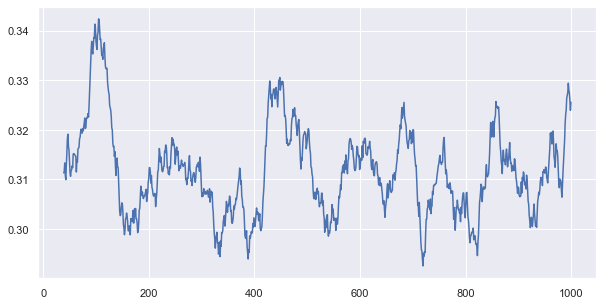

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

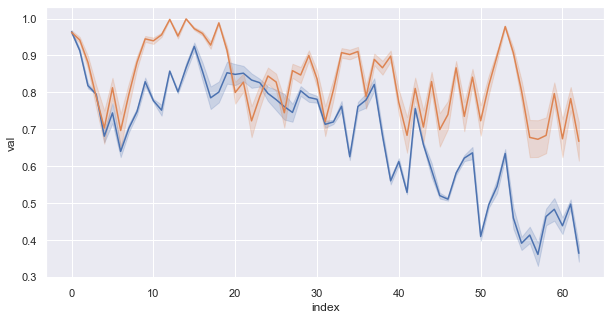

theta x: pi/8, theta v : pi/4, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

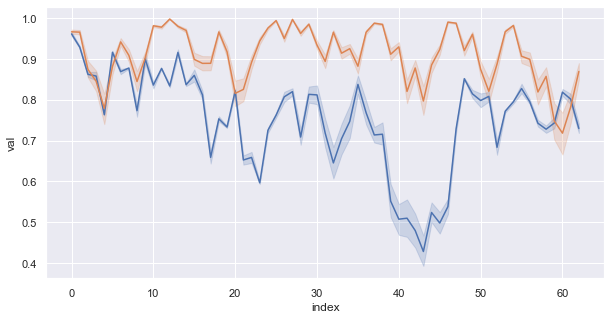

theta x: pi/8, theta v : pi/5, trained: True


tf.Tensor([0.30888772+0.j 0.8867052 +0.j], shape=(2,), dtype=complex64)


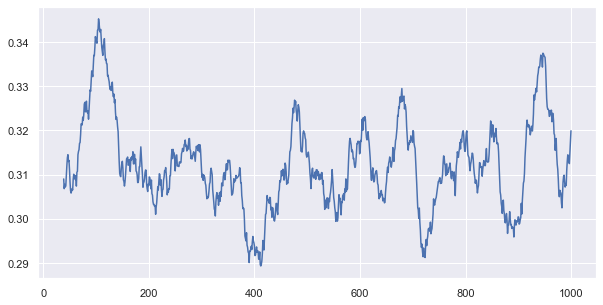

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

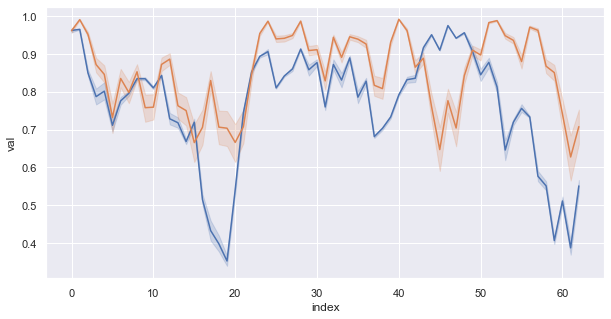

theta x: pi/8, theta v : pi/5, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

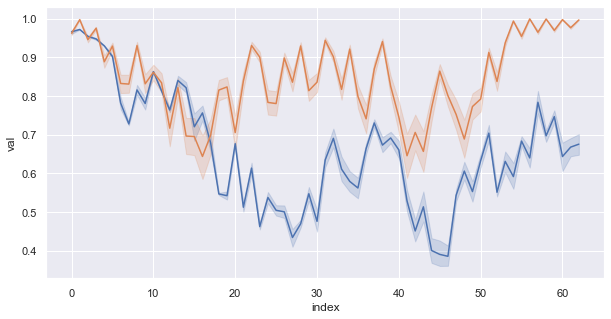

theta x: pi/8, theta v : pi/6, trained: True


tf.Tensor([0.77684695+0.j 0.29431704+0.j], shape=(2,), dtype=complex64)


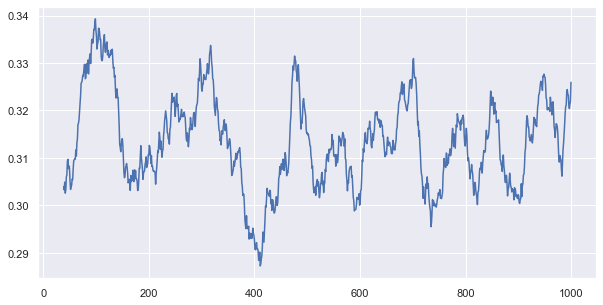

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

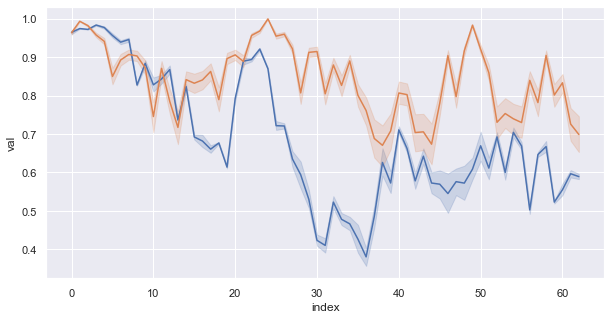

theta x: pi/8, theta v : pi/6, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

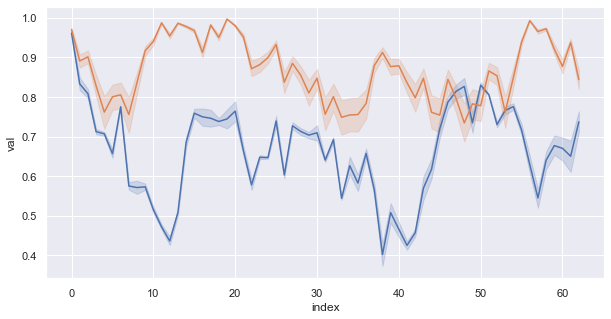

theta x: pi/8, theta v : pi/7, trained: True


tf.Tensor([0.4621311 +0.j 0.84148777+0.j], shape=(2,), dtype=complex64)


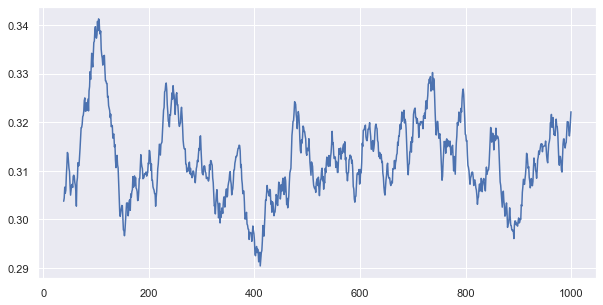

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

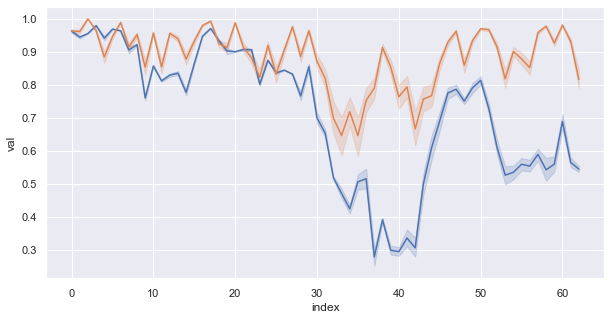

theta x: pi/8, theta v : pi/7, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

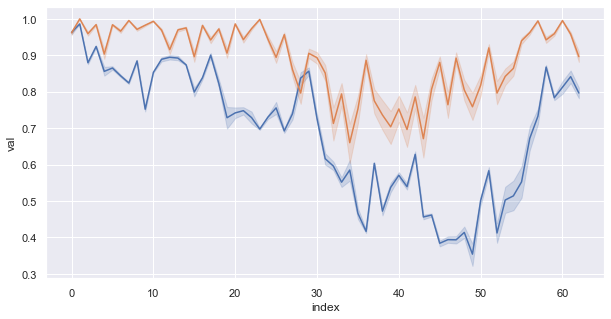

theta x: pi/8, theta v : pi/8, trained: True


tf.Tensor([0.7012219+0.j 0.8918223+0.j], shape=(2,), dtype=complex64)


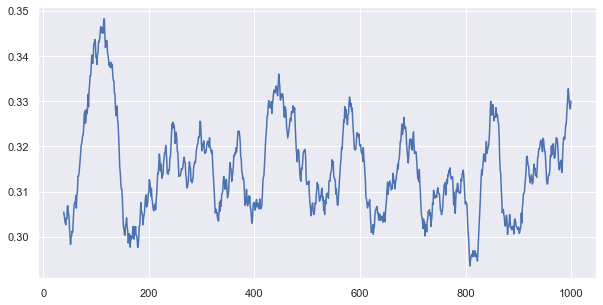

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

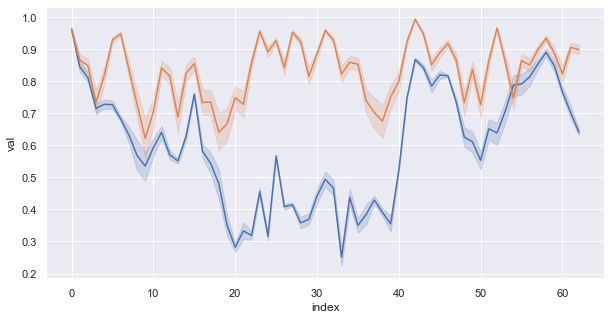

theta x: pi/8, theta v : pi/8, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

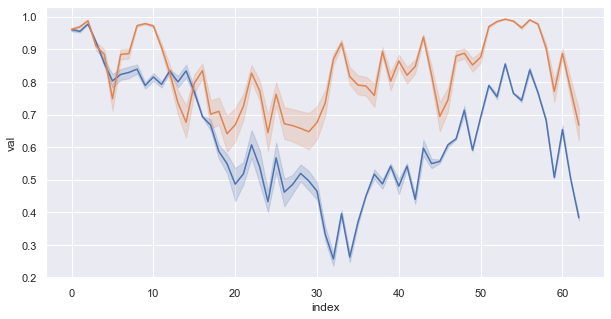

theta x: pi/8, theta v : pi/9, trained: True


tf.Tensor([0.7051425+0.j 0.8977874+0.j], shape=(2,), dtype=complex64)


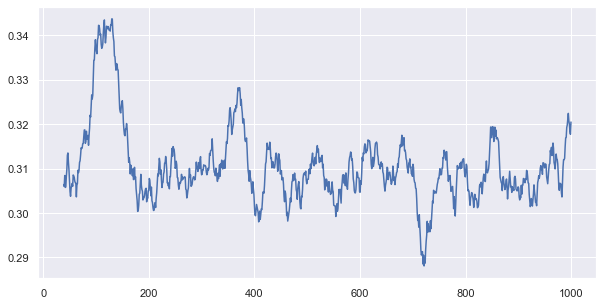

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

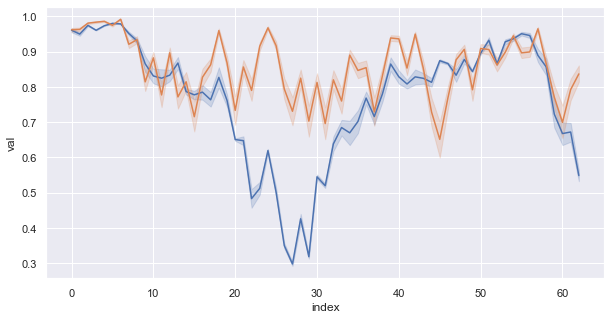

theta x: pi/8, theta v : pi/9, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

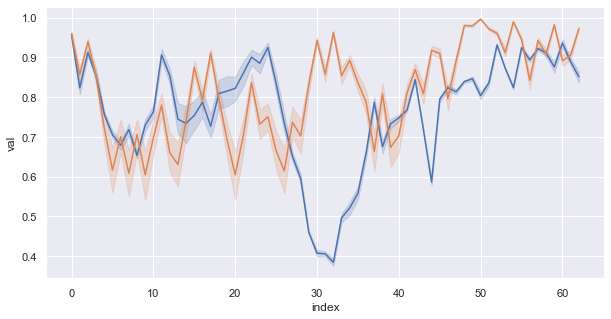

theta x: pi/8, theta v : pi/10, trained: True


tf.Tensor([0.5037146+0.j 0.9989606+0.j], shape=(2,), dtype=complex64)


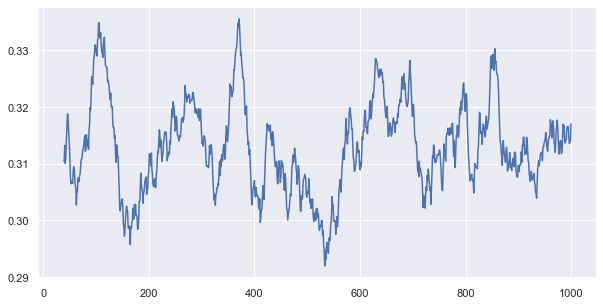

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

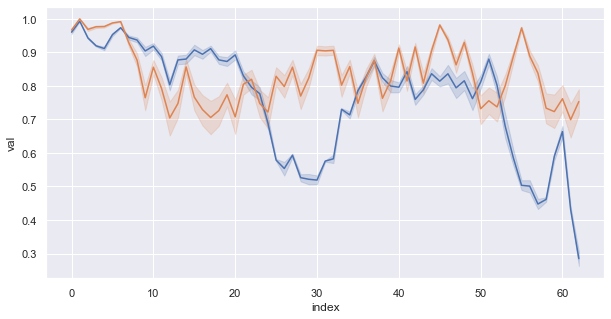

theta x: pi/8, theta v : pi/10, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

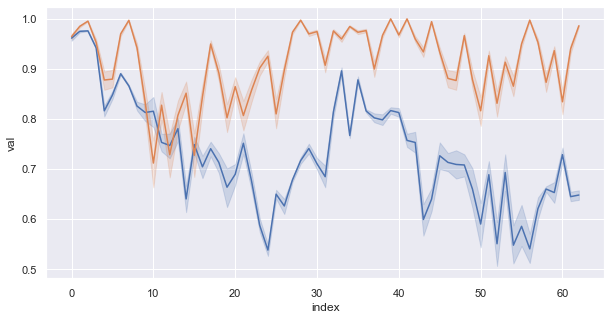

theta x: pi/8, theta v : pi/12, trained: True


tf.Tensor([0.48345324+0.j 0.8447478 +0.j], shape=(2,), dtype=complex64)


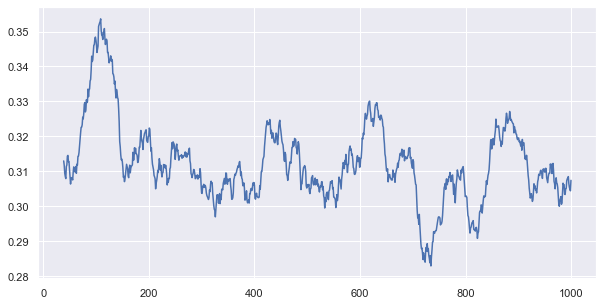

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

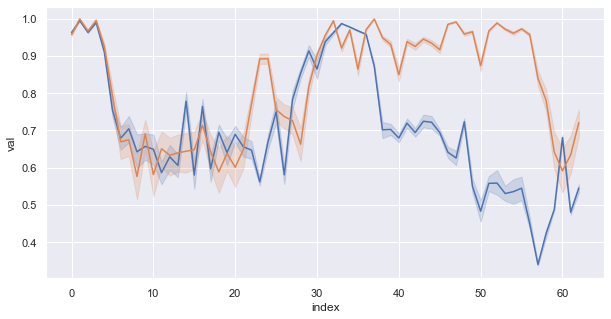

theta x: pi/8, theta v : pi/12, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

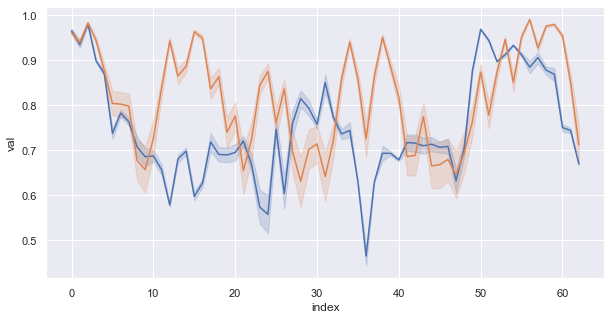

theta x: pi/8, theta v : pi/16, trained: True


tf.Tensor([0.47155473+0.j 0.78414357+0.j], shape=(2,), dtype=complex64)


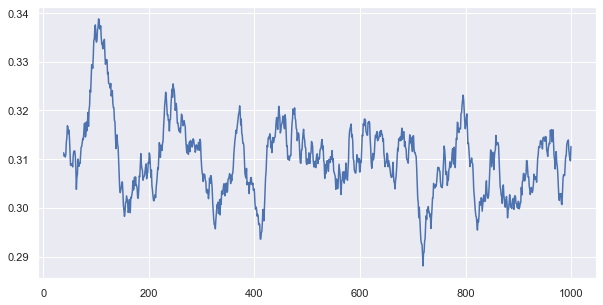

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

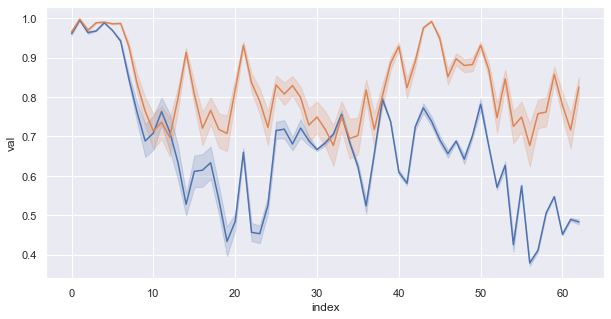

theta x: pi/8, theta v : pi/16, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

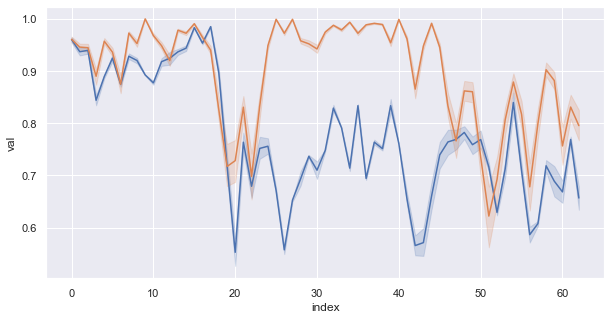

In [6]:
for n, nv in [(8,4),(8,5),(8,6),(8,7),(8,8),(8,9),(8,10),(8,12),(8,16)]:
    wx = np.pi/n
    v = np.pi/nv # x rotation
    poly_deg = 64
    
    for train in (True, False):
        print("theta x: pi/%s, theta v : pi/%s, trained: %s" % (n,nv, train))
        
        # The intput theta training values 
        th_in = tf.constant([[wx,v],[wx,0]],dtype=tf.float32)
        # The desired real part of p(x) which is the upper left value in the unitary of the qsp sequence
        expected_outputs = tf.constant([[0,1],[1,0]], dtype=tf.float32)


        qsp, model = construct_qsp_model2(poly_deg)
        
        if train:
            history = model.fit(x=th_in, y=expected_outputs, epochs=1000,verbose=0)
            loss = pd.Series(history.history['loss'])
            plt.plot(loss.rolling(40).mean().dropna())
            print(qsp.unitary(th_in))

            plt.show()
            
        noise = []
        no_noise = []
        index = []
        for _ in range(100):
            final, intermediate = qsp.unitary(th_in, True )

            noise.extend([float(t[0]) for t in intermediate])
            no_noise.extend([float(t[1]) for t in intermediate])
            index.extend([i for i in range(len(intermediate))])
        noise = pd.DataFrame({"val": noise, "index": index})
        no_noise = pd.DataFrame({"val": no_noise, "index": index})
        sns.lineplot(data=noise, x="index", y="val")
        sns.lineplot(data=no_noise, x="index", y="val")
        plt.show()

theta x: pi/8, theta v : pi/20, trained: True


tf.Tensor([0.5999053 +0.j 0.99748695+0.j], shape=(2,), dtype=complex64)


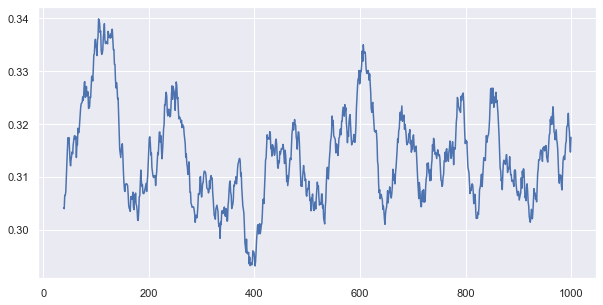

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

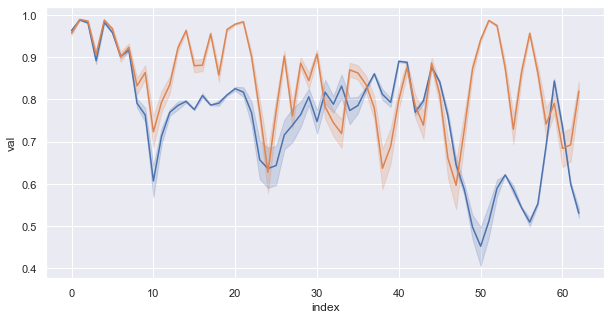

theta x: pi/8, theta v : pi/20, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

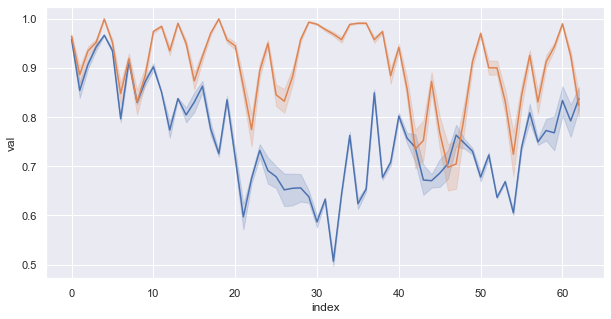

theta x: pi/8, theta v : pi/24, trained: True


tf.Tensor([0.5516849 +0.j 0.99717414+0.j], shape=(2,), dtype=complex64)


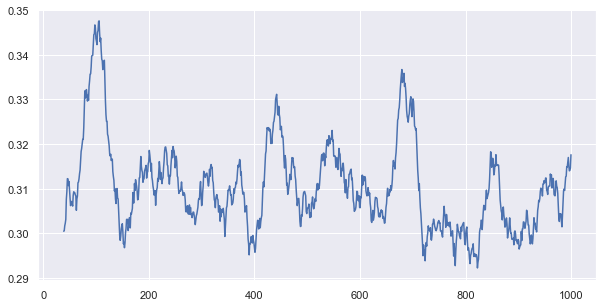

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

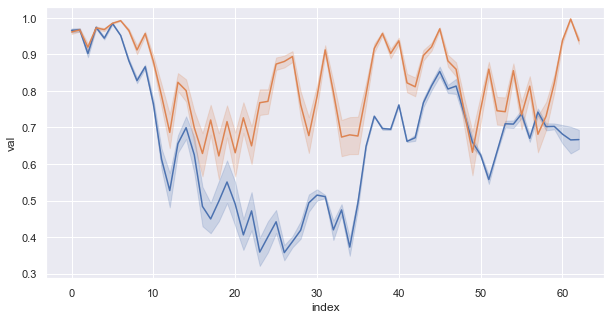

theta x: pi/8, theta v : pi/24, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

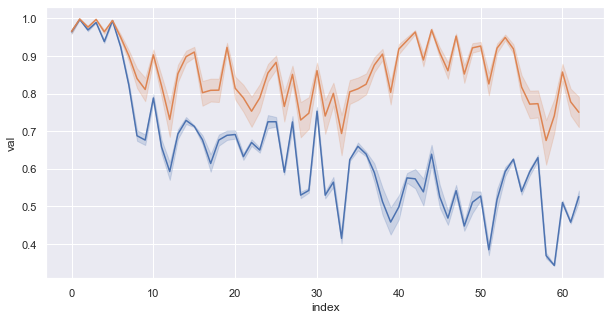

theta x: pi/8, theta v : pi/32, trained: True


tf.Tensor([0.3016783 +0.j 0.48057643+0.j], shape=(2,), dtype=complex64)


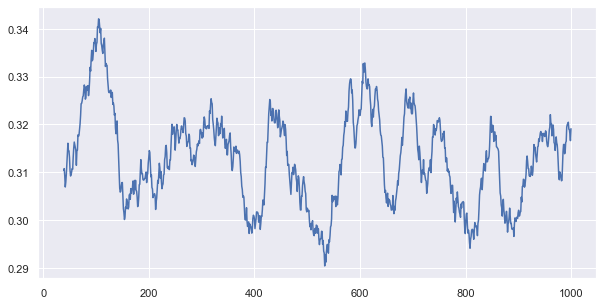

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

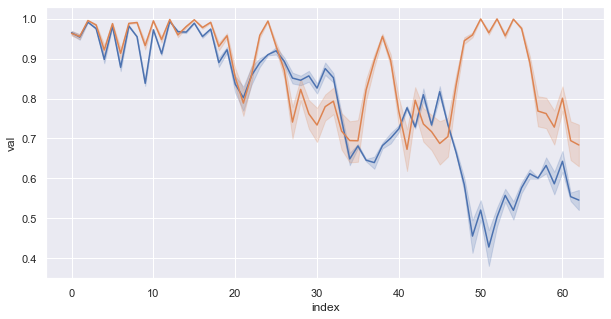

theta x: pi/8, theta v : pi/32, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

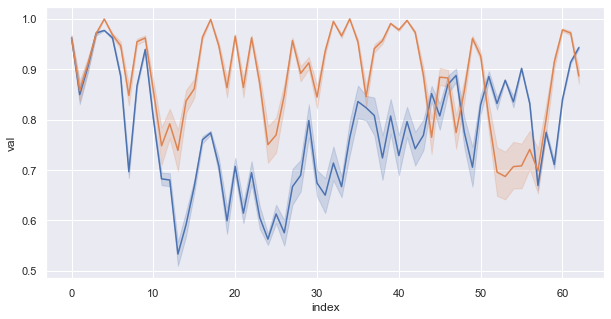

theta x: pi/8, theta v : pi/38, trained: True


tf.Tensor([0.56348985+0.j 0.51599234+0.j], shape=(2,), dtype=complex64)


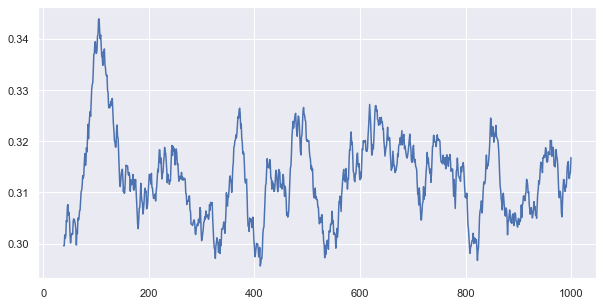

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

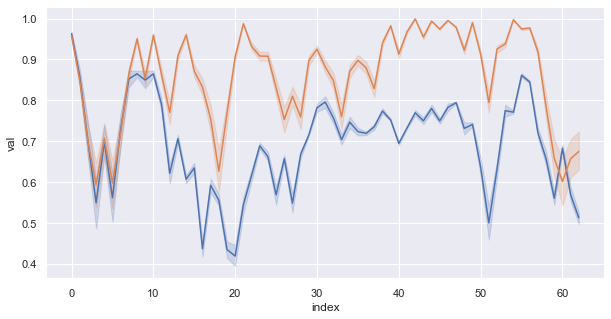

theta x: pi/8, theta v : pi/38, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

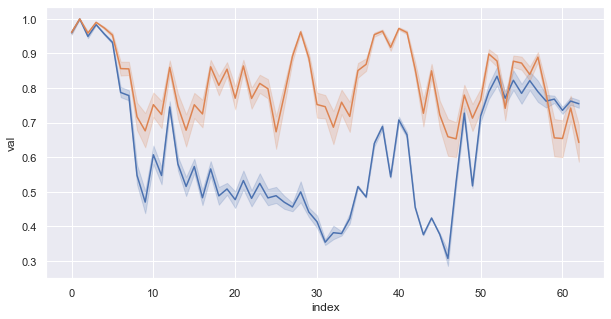

theta x: pi/2, theta v : pi/8, trained: True


tf.Tensor([0.49755603+0.j 0.9999999 +0.j], shape=(2,), dtype=complex64)


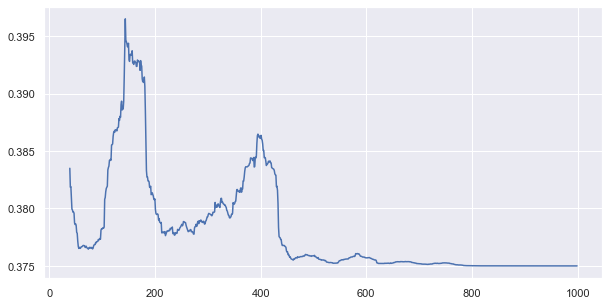

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

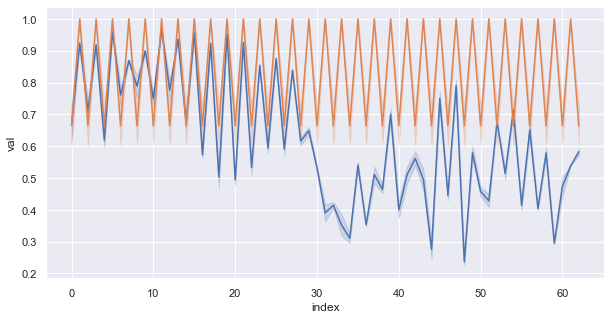

theta x: pi/2, theta v : pi/8, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

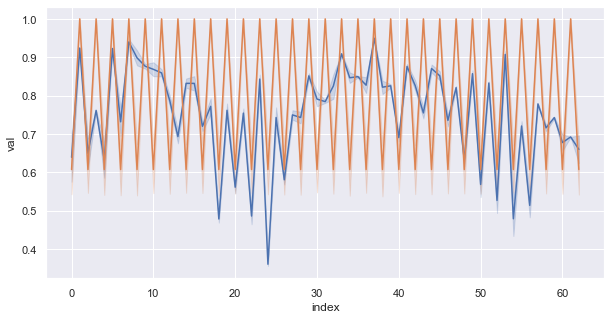

theta x: pi/4, theta v : pi/8, trained: True


tf.Tensor([0.5067737+0.j 0.5416189+0.j], shape=(2,), dtype=complex64)


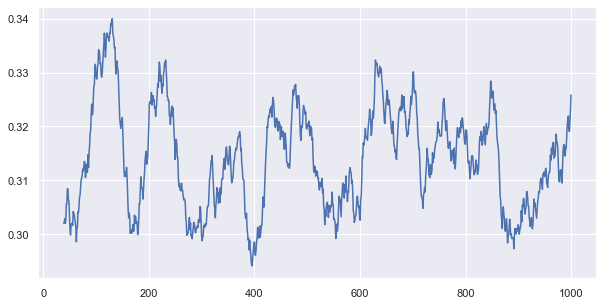

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

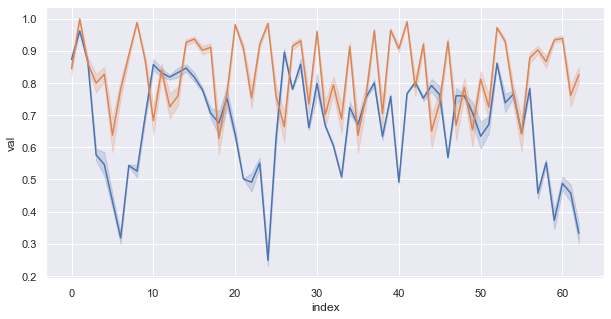

theta x: pi/4, theta v : pi/8, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

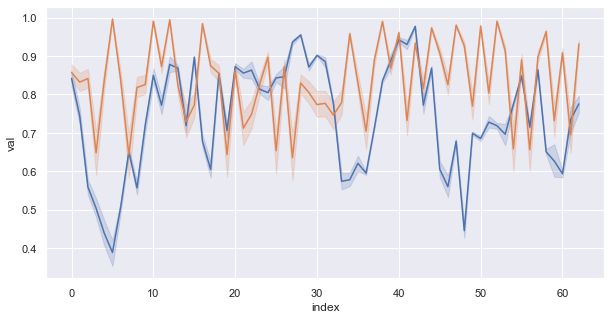

theta x: pi/6, theta v : pi/8, trained: True


tf.Tensor([0.48708344+0.j 0.71592706+0.j], shape=(2,), dtype=complex64)


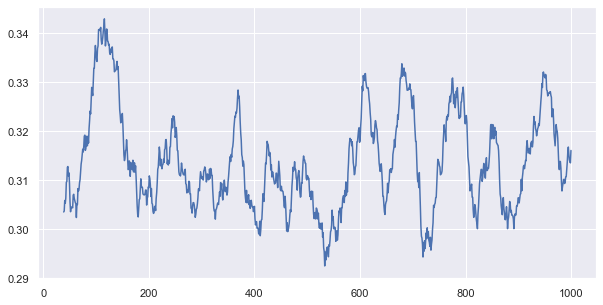

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

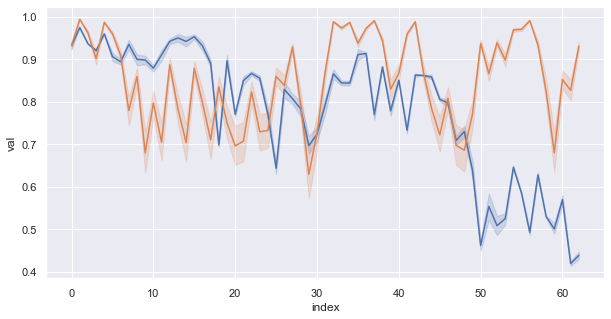

theta x: pi/6, theta v : pi/8, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

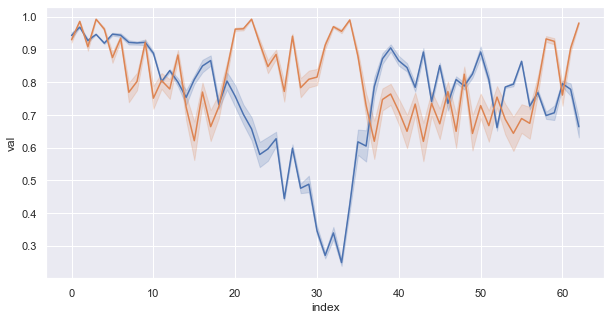

theta x: pi/8, theta v : pi/8, trained: True


tf.Tensor([0.5111201+0.j 0.9971421+0.j], shape=(2,), dtype=complex64)


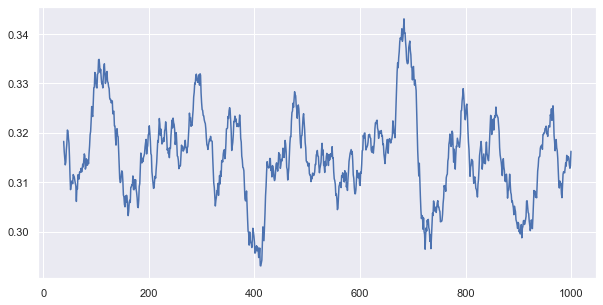

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

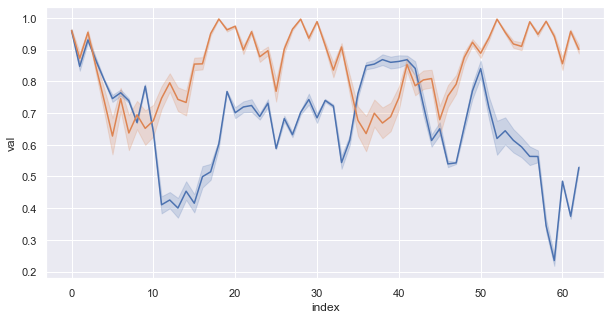

theta x: pi/8, theta v : pi/8, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

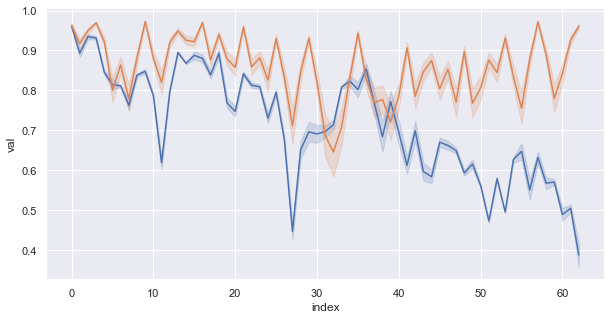

theta x: pi/10, theta v : pi/8, trained: True


tf.Tensor([0.4271214 +0.j 0.98623276+0.j], shape=(2,), dtype=complex64)


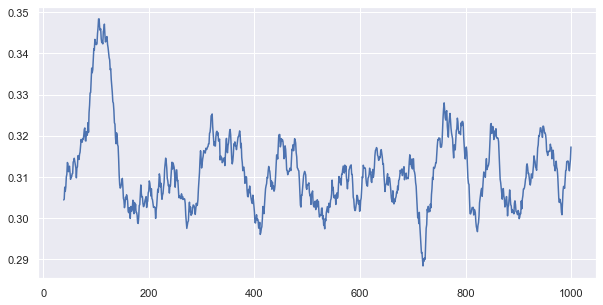

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

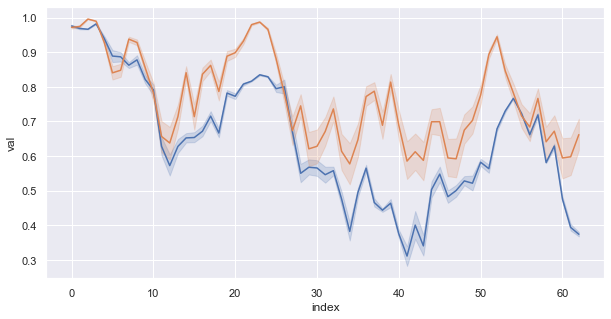

theta x: pi/10, theta v : pi/8, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

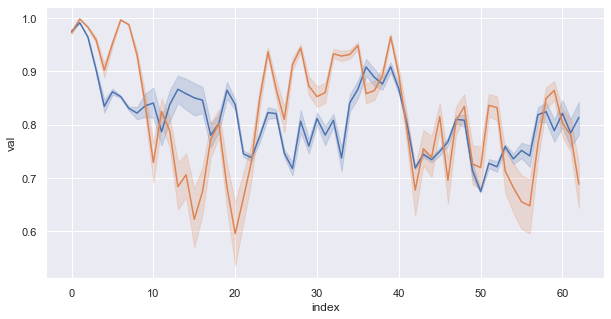

theta x: pi/12, theta v : pi/8, trained: True


tf.Tensor([0.70226204+0.j 0.77995837+0.j], shape=(2,), dtype=complex64)


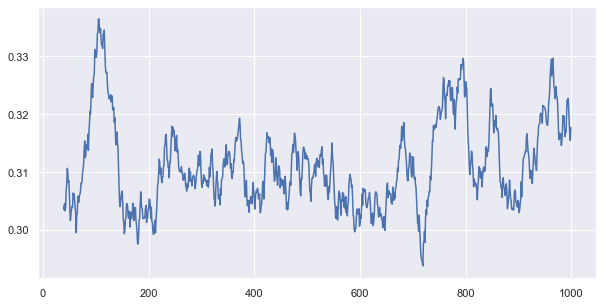

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

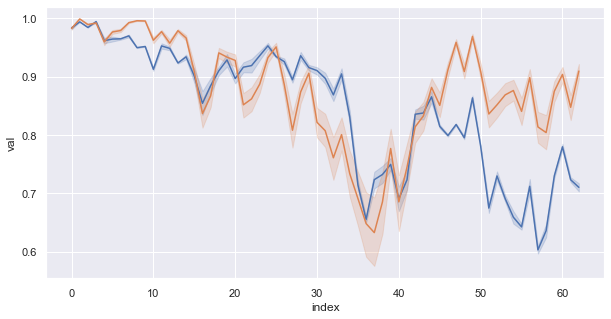

theta x: pi/12, theta v : pi/8, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

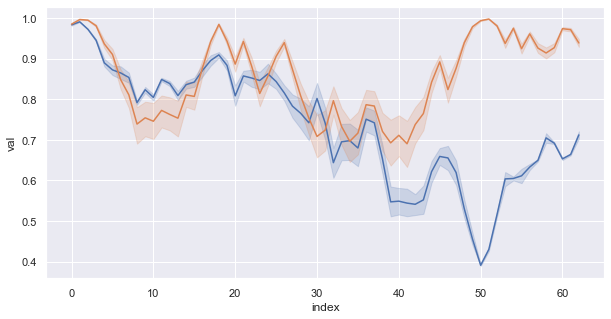

theta x: pi/16, theta v : pi/8, trained: True


tf.Tensor([0.4745182+0.j 0.6065043+0.j], shape=(2,), dtype=complex64)


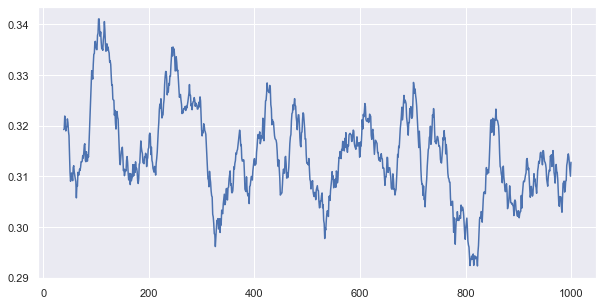

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

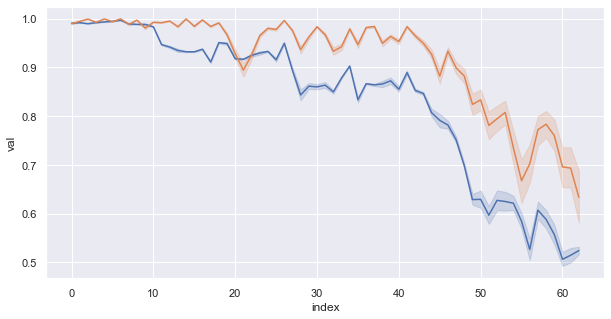

theta x: pi/16, theta v : pi/8, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

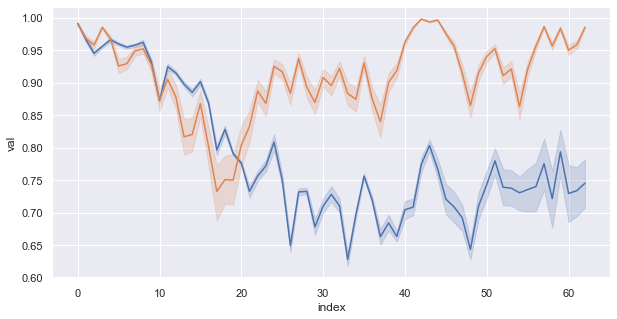

theta x: pi/32, theta v : pi/64, trained: True


tf.Tensor([0.6972636+0.j 0.7225638+0.j], shape=(2,), dtype=complex64)


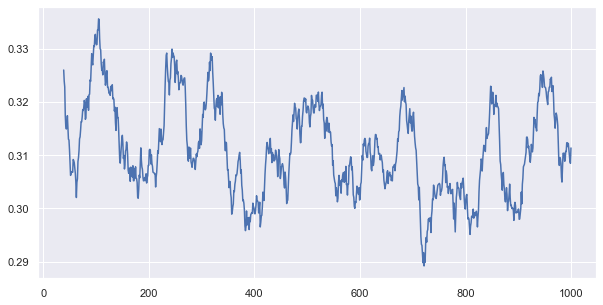

/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

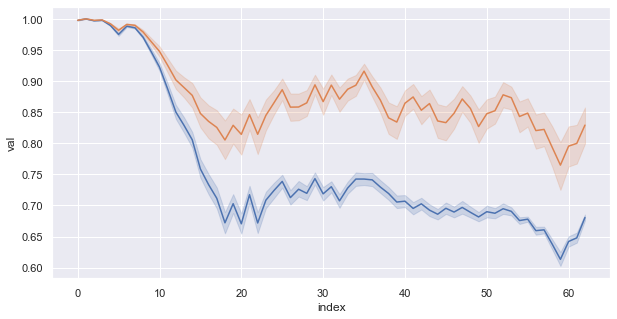

theta x: pi/32, theta v : pi/64, trained: False


/Users/jdocter/opt/anaconda3/envs/qsp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:986: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


<AxesSubplot:xlabel='index', ylabel='val'>

<AxesSubplot:xlabel='index', ylabel='val'>

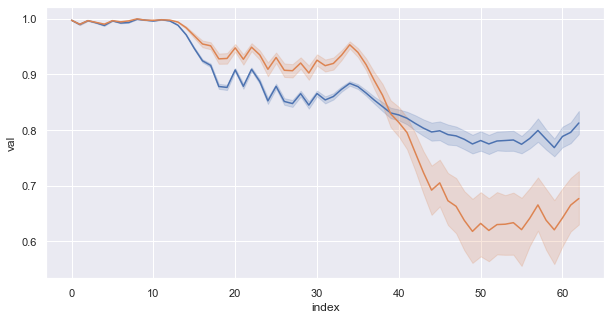

In [7]:
for n, nv in [(8,20),(8,24),(8,32),(8,38),(2,8),(4,8),(6,8),(8,8),(10,8),(12,8),(16,8),(32,64)]:
    wx = np.pi/n
    v = np.pi/nv # x rotation
    poly_deg = 64
    
    for train in (True, False):
        print("theta x: pi/%s, theta v : pi/%s, trained: %s" % (n,nv, train))
        
        # The intput theta training values 
        th_in = tf.constant([[wx,v],[wx,0]],dtype=tf.float32)
        # The desired real part of p(x) which is the upper left value in the unitary of the qsp sequence
        expected_outputs = tf.constant([[0,1],[1,0]], dtype=tf.float32)


        qsp, model = construct_qsp_model2(poly_deg)
        
        if train:
            history = model.fit(x=th_in, y=expected_outputs, epochs=1000,verbose=0)
            loss = pd.Series(history.history['loss'])
            plt.plot(loss.rolling(40).mean().dropna())
            print(qsp.unitary(th_in))

            plt.show()
            
        noise = []
        no_noise = []
        index = []
        for _ in range(100):
            final, intermediate = qsp.unitary(th_in, True )

            noise.extend([float(t[0]) for t in intermediate])
            no_noise.extend([float(t[1]) for t in intermediate])
            index.extend([i for i in range(len(intermediate))])
        noise = pd.DataFrame({"val": noise, "index": index})
        no_noise = pd.DataFrame({"val": no_noise, "index": index})
        sns.lineplot(data=noise, x="index", y="val")
        sns.lineplot(data=no_noise, x="index", y="val")
        plt.show()